# Notebook for studying "STUMPY Basics" in Tutorials.

#### [References]
- STUMPY Basics
 - https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html
    
- STUMPY documentation:  
 - https://stumpy.readthedocs.io/en/latest/  

- The Matrix Profile
 - https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html

- GitHub repository of stumpy
 - https://github.com/TDAmeritrade/stumpy

---
## z-normalized Euclidean distanceについて
参考(Youtube)：[Time Series data Mining Using the Matrix Profile part 2](https://www.youtube.com/watch?v=LnQneYvg84M&t=374s)

以下の2つの時系列 $\boldsymbol{x}$, $\boldsymbol{y}$ に対するz-normalized Euclidean distanceを考える。

$$
    \boldsymbol{x} = x_{1}, x_{2}, \cdots , x_{n} \\
    \boldsymbol{y} = y_{1}, y_{2}, \cdots , y_{n} \\
$$
に対して、z-normalized Euclidean distance $d(\boldsymbol{x}, \boldsymbol{y})$ を以下で定義する。
$$
    d(\boldsymbol{x}, \boldsymbol{y}) := \sqrt(\sum_{i=1}^{n} (\hat{x}_{i} - \hat{y}_{i})^2)
$$
ただし、ここで $\hat{x}_{i}$ および $\hat{y}_{i}$ は

$$
    \hat{x}_{i} = \frac{x_{i}-\mu_{x}}{\sigma_{x}} \\
    \hat{y}_{i} = \frac{y_{i}-\mu_{x}}{\sigma_{y}} \\
$$
であるとする。

---

In [1]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

# matplotlibで使われるデフォルト値を変更する。
plt.rcParams["figure.figsize"] = [25, 3]  # width, height
plt.rcParams['xtick.direction'] = 'out'

今回利用する`streamgen dataset`というデータセットは発電所の蒸気発生器を模倣するシミュレータで生成されたデータである。  
このデータの特徴は、kg/s単位の出力蒸気流量遠隔測定であり、データは3秒ごとに「サンプリング」され、9600点のデータ点数がある。  
ここでは、特徴量`steam flow`を可視化する。

In [2]:
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
print(steam_df.shape)
steam_df.head()

(9600, 4)


,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955
3,325.00252,0.027054,0.326187,12.430107
4,326.65276,0.285649,0.753776,13.681666


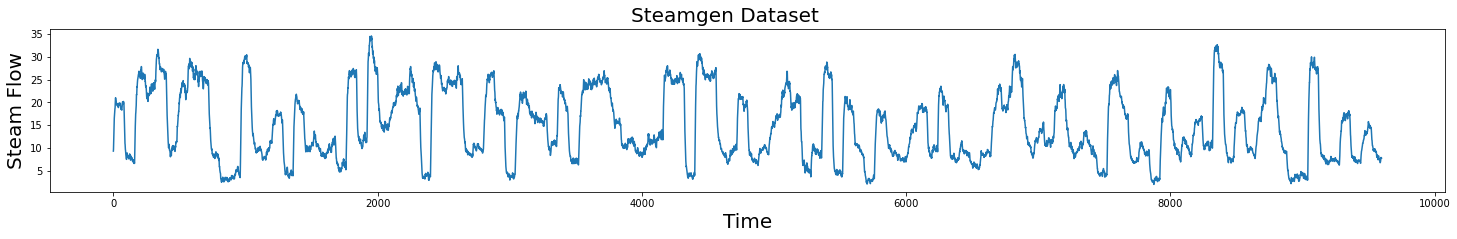

In [3]:
plt.suptitle('Steamgen Dataset', fontsize='20')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Steam Flow', fontsize='20')
plt.plot(steam_df['steam flow'].values)
plt.show()

特徴量`steam flow`の中の類似したパターンを目の子で見つけるのは難しいが、実は下の2段組の図において<font color="orange">オレンジ色</font>部分と<font color="green">緑色</font>部分は類似パターンとなっている。  
グレーにハッチされた部分を重ね合わせると、2つのsubsequenceが類似しているのがよくわかる。

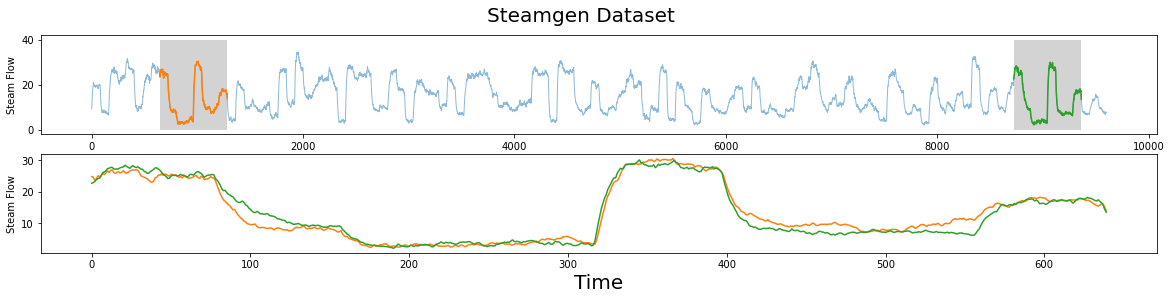

In [4]:
m = 640
fig, axs = plt.subplots(2, figsize=(20, 4))
plt.suptitle('Steamgen Dataset', fontsize='20')
axs[0].set_ylabel("Steam Flow", fontsize='10')
axs[0].plot(steam_df['steam flow'], alpha=0.5, linewidth=1)
axs[0].plot(steam_df['steam flow'].iloc[643:643+m])
axs[0].plot(steam_df['steam flow'].iloc[8724:8724+m])
rect = Rectangle((643, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((8724, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel("Time", fontsize='20')
axs[1].set_ylabel("Steam Flow", fontsize='10')
axs[1].plot(steam_df['steam flow'].values[643:643+m], color='C1')
axs[1].plot(steam_df['steam flow'].values[8724:8724+m], color='C2')
plt.show()

Matrix Profileを用いれば、このようなmotiefを素早く見つけることができ、また時系列内の全てのsubsequenceに対して、その'最近接'を識別できる。  
以下では、実際にMatrix Profileを用いて類似motiefを探す方法を示す。








In [5]:
m = 640
mp = stumpy.stump(steam_df['steam flow'], m)

`stump`関数は(主に)以下の2つの引数を取る。（正確には[STUMPY API](https://stumpy.readthedocs.io/en/latest/api.html#stumpy.stump)を参照）

1. 第1引数： 時系列データ
2. 第2引数： ウィンドウサイズ, `m`

また、`stump`関数はnumpyu行列(ndarray)を返し、それぞれの列は以下のとおり。
1. 第1列目： matrix profile
2. 第2列目： matrix profileのそれぞれの要素に対し、その要素が選ばれる行における、その最小要素のindex（日本語がﾍﾝ）
3. 第3列目： <font color = 'red'>left matrix profile(?) のindex</font>
4. 第4列目： <font color = 'red'>right matrix profile(?) のindex</font>

今回は`m = 640`としているが、ウィンドウサイズは一般的にはドメイン知識を用いて決める。今の場合、`m = 640`と言うのは約30分間程度のデータになっている。（このデータのサンプリング周期は3秒間であった。)  
`stump`関数の出力は上で示したとおり、1列目はmatrix profile、2列目はmatrix profileのindexとなる。類似motifのindexの位置を見つけるためには、matrix profileの最小値とその(matrix profileの要素としての)indexを見つける必要がある。







In [6]:
motif_idx = np.argsort(mp[:, 0])[0]
print(f"The motif is located at index {motif_idx}")

The motif is located at index 643


`motif_idx`はmatrix profileの中の最小値がいる位置(index)を表している。`stump`関数の戻り値ndarrayの第2列目の値を見ることにより、`motif_idx`の位置から始まる長さ`m`分の波形の類似波形の先頭位置がわかる。

In [7]:
nearest_neighbor_idx = mp[motif_idx, 1]
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

The nearest neighbor is located at index 8724


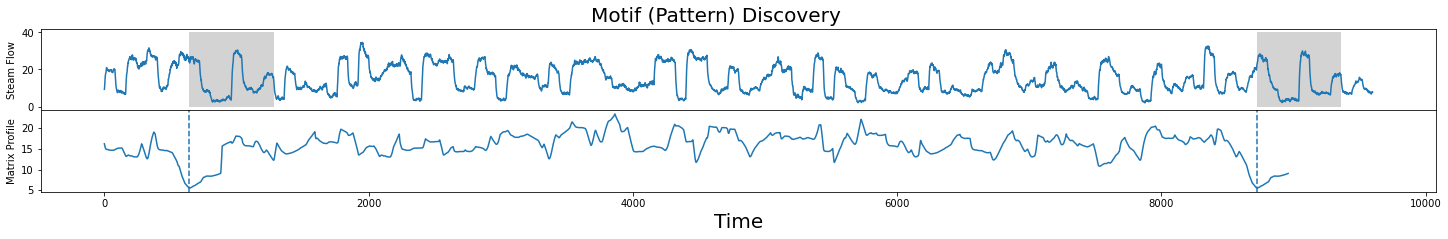

In [8]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='20')

axs[0].plot(steam_df['steam flow'].values)
axs[0].set_ylabel('Steam Flow', fontsize='10')
rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='10')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()